# Telecom Machine Learning notebook

## Imports


In [24]:
## for plotting
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
## for data
import pandas as pd
import numpy as np
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
#from lime import lime_tabular  #to install this : pip install lime
import sys
import pyodbc

np.set_printoptions(threshold=sys.maxsize)

#dd
#Clustering 

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#dependency
import scipy.stats as st
from pylab import rcParams
import seaborn as sns


#num qual analysis
#Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#Missing values
from sklearn.impute import SimpleImputer
#Scaling 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,Normalizer,MaxAbsScaler

#Variance
import statistics 


#Modeling
from sklearn.model_selection import GridSearchCV,validation_curve
from sklearn.metrics import plot_confusion_matrix,roc_curve,roc_auc_score, classification_report,auc,precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Reconstructing dataframe from our data mart

## df_init : complete data frame
## num_quests : numerical questions

In [25]:

conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-HAI35CJ;'
                      'Database=telecom;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()



##no questions
query="""SELECT c.Client_id,c.Name,c.Sexe,o.Operator_name,r.City
 from client c, questionnaire q, question qt,Operator o, Region r, Service s
where c.Client_id=q.client_id 
	and r.region_id=q.region_id
	and s.service_id=q.service_id
	and o.operator_id=q.operator_id
	and qt.question_id=q.question_id 
	and qt.question='57  Q11.4 La compréhension de votre demande par le commercial'

	
	
	order by c.client_id"""
sql_query = pd.read_sql_query(query,conn)
cursor = conn.cursor()

sql_query = pd.read_sql_query(query,conn)



df_init=sql_query.copy()

#getting all questions
query="""SELECT  question_id,[question]      
  FROM [telecom].[dbo].[Question]"""
cursor = conn.cursor()

sql_query = pd.read_sql_query(query,conn)

questions=sql_query.copy()
sql_query.head()

questions['question'][questions['question_id']==1].values[0]



#filling questions and their answers
for q in range(1,126) :
    #print(q)
    query="SELECT q.response from client c, questionnaire q, question qt,Operator o, Region r, Service s where c.Client_id=q.client_id and r.region_id=q.region_id and s.service_id=q.service_id and o.operator_id=q.operator_id and qt.question_id="+str(q)+" and qt.question_id=q.question_id order by c.client_id"
    cursor = conn.cursor()

    sql_query = pd.read_sql_query(query,conn)
    
    question=questions['question'][questions['question_id']==q].values[0]
    
    df_init[question]=sql_query.values
df_init.head()
#selecting numerical features    
query="SELECT [question] FROM [telecom].[dbo].[Question] where typeResponse=0 or typeResponse=3"
cursor = conn.cursor()

sql_query = pd.read_sql_query(query,conn)

num_quests=sql_query.copy()
 


## Replacing bad values, converting columns to numerical and replacing -1 by empty values

In [26]:
#replacing bad values
df_init.replace({'Oui':1,'Non':0,'NE SAIT PAS':0,"1.Oui":1,"2.Non":0,"3.Non":0,"1.Oui, une fois":1,
                "2.Oui, plusieurs fois":1,"2.Non, mon problème / ma demande était résolue":0,"3.Ne sait pas":0
                ,"4.Ne souhaite pas changer":0},inplace=True)
#print(num_quests['question'].values)
##convert cols to numeric,
for k in num_quests['question'].values:
    
    df_init[k] = pd.to_numeric(df_init[k], downcast="integer")
##replacing -1 with empty values
df_init.replace({-1:np.NaN,"-1":"Pas de réponse"},inplace=True)


# Recommending system using our internal data

### We selected the questions concerning services provided by the operators

In [27]:
##Recommender
dd=df_init.copy()
cols_rec=["Client_id","85 facilite d'utilisation et fonctionnement de  Appelez jusqu'à six ou Conf Call pro ou Appel en conférence",
"84  facilite d'utilisation et fonctionnement de  Messagerie vocale",
"83  facilite d'utilisation et fonctionnement de  Orange fidélité ou Points Merci ou  Kelma",
"82facilite d'utilisation et fonctionnement de  SOS crédit / Minute SOS/ SOS Solde",
"81 facilite d'utilisation et fonctionnement de Transfert Internet",
"80 facilite d'utilisation et fonctionnement de   Transfert de crédit",
"102 Q20. Globalement  le service roaming  de votre operateur principale ?",
"109 Q23. Globalement comment évaluez-vous la qualité de la connexion internet  de votre operateur principale ?",
"98 globalement Orange Money",
"99 globalementMobicash (ooredoo)",
"100 globalement Mdinar (TT)"]
dd=dd[cols_rec]
cols_rec1=["85 facilite d'utilisation et fonctionnement de  Appelez jusqu'à six ou Conf Call pro ou Appel en conférence",
"84  facilite d'utilisation et fonctionnement de  Messagerie vocale",
"83  facilite d'utilisation et fonctionnement de  Orange fidélité ou Points Merci ou  Kelma",
"82facilite d'utilisation et fonctionnement de  SOS crédit / Minute SOS/ SOS Solde",
"81 facilite d'utilisation et fonctionnement de Transfert Internet",
"80 facilite d'utilisation et fonctionnement de   Transfert de crédit",
"102 Q20. Globalement  le service roaming  de votre operateur principale ?",
"109 Q23. Globalement comment évaluez-vous la qualité de la connexion internet  de votre operateur principale ?",
"98 globalement Orange Money",
"99 globalementMobicash (ooredoo)",
"100 globalement Mdinar (TT)"]
num_cols_dd=['Client_id','Conf Call','Messagerie Vocale','Points fidélité','SOS crédit','Transfert Internet','Transfert Crédit',
           'Service Roaming','Connexion Internet','Orange Money','Mobicash Ooredoo','Mdinar']
dd.columns=num_cols_dd
dd.set_index('Client_id',inplace=True)
services=dd.columns




#### In order to recommand a service to a customer, we have to see how strong the correlation is between two services, we do that by calculating the covariance between two service vectors and their ratings

In [28]:
def recommend(col,corr=0.9,nb_items=5):
    similar_to_confcall = dd.corrwith(dd[col])
    similar_to_confcall.dropna(inplace=True)
    similar_to_confcall.sort_values(inplace=True,ascending=False)

   

    i=0
    recs={}
    for k,v in similar_to_confcall.items():
        i+=1
        if(v>0.9 and k!=col):
            #print(k,v)
            recs[k]=v
        if(i==nb_items):
            break
    return recs

In [29]:
for s in services[1:]:
    
    print('Service : ',s)
    print(recommend(s))

Service :  Messagerie Vocale
{'SOS crédit': 0.9774352498300329, 'Transfert Internet': 0.9762867677640277, 'Points fidélité': 0.9583163565074374, 'Conf Call': 0.921486974597146}
Service :  Points fidélité
{'SOS crédit': 1.0, 'Service Roaming': 1.0, 'Conf Call': 0.9999999999999999, 'Transfert Internet': 0.9999999999999999}
Service :  SOS crédit
{'Points fidélité': 1.0, 'Connexion Internet': 1.0, 'Conf Call': 0.9999999999999999, 'Transfert Internet': 0.9893752096954197}
Service :  Transfert Internet
{'Conf Call': 0.9999999999999999, 'Points fidélité': 0.9999999999999999, 'SOS crédit': 0.9893752096954197, 'Messagerie Vocale': 0.9762867677640277}
Service :  Transfert Crédit
{'Conf Call': 0.9999999999999999}
Service :  Service Roaming
{'Points fidélité': 1.0}
Service :  Connexion Internet
{'Conf Call': 1.0, 'SOS crédit': 1.0}
Service :  Orange Money
{'Points fidélité': 0.9999999999999994}
Service :  Mobicash Ooredoo
{}
Service :  Mdinar
{}


# Clustering

#### In order to determine if our client is satisfied or not, we are going to use the following formula  
Satisfied if sum(ratings)/len(filled ratings) >= 5

#### We are going to use only service rating columns

In [30]:
d_cluster=dd.copy()
d_cluster.head()

,Conf Call,Messagerie Vocale,Points fidélité,SOS crédit,Transfert Internet,Transfert Crédit,Service Roaming,Connexion Internet,Orange Money,Mobicash Ooredoo,Mdinar
Client_id,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,7.0,7.0,NaN,6.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Replacing missing values with 5 which is the average mark to avoid bias

In [31]:
d_cluster.replace({np.NaN:5},inplace=True)

### Adding the satisfied column to our dataframe

In [32]:
##adding satisfaction column :
d_cluster=dd.copy()
sat=[]
for k,v in d_cluster.iterrows():
    
    #print(v.values,v.sum(),v.count())
    if(v.count()>0):
        if (v.sum()/v.count())>=5:
            sat.append(1)
        else:
            sat.append(0)
    else:
        sat.append(0)
    #print("sum",sum(v.values))
d_cluster['satisfied']=sat
d_cluster.head()
df_init['satisfied']=sat
#1 unsat, 2 sat
len(d_cluster[d_cluster['satisfied']==1])

851

#### Applying Hierarchical agglomerative clustering

In [34]:
d_cluster.replace({np.NaN:5},inplace=True)
X=d_cluster[num_cols_dd[1:]].values
Z = linkage(X, 'ward')


#### Calculating the cophenet distance (the distance between two disjoint clusters under a parent cluster)

In [35]:


c, coph_dists = cophenet(Z, pdist(X))
c

0.6431975384720635

### Plotting the dendrogram

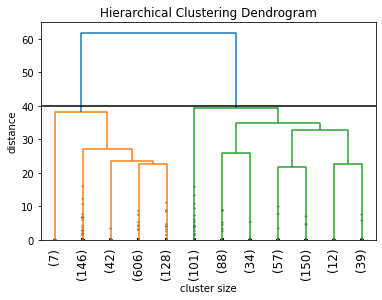

In [36]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cluster size')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(y=40, c='k')
plt.show()

### We can see with distance 40, our dataset is divided in two major clusters

#### Now we are going to put our datapoint into their respective clusters

In [37]:

from scipy.cluster.hierarchy import fcluster
max_d = 40
clusters = fcluster(Z, max_d, criterion='distance')
clusters=np.where(clusters==2, 0, clusters)


## Calculating the difference between the regrouping by formula and by clustering

In [38]:
s_sat=0
s_unsat=0
i=0
for i in clusters:
    if(i==1):
        s_sat+=1
    else:
        s_unsat+=1


c_sat=len(d_cluster[d_cluster['satisfied']==1])
c_unsat=len(d_cluster[d_cluster['satisfied']==0])

print('Formula :')
print('Satisfied :',c_sat,'Unsatisfied :',c_unsat)
print('Clusters :')
print('Satisfied :',s_sat,'Unsatisfied :',s_unsat)


Formula :
Satisfied : 851 Unsatisfied : 559
Clusters :
Satisfied : 929 Unsatisfied : 481


## If we plot our clusters regarding to two services, we can see that red points tend to have high ratings while the green ones are generally low, we can conclude that in our dataset exists two types of clients : mostly satisfied and mostly unsatisfied

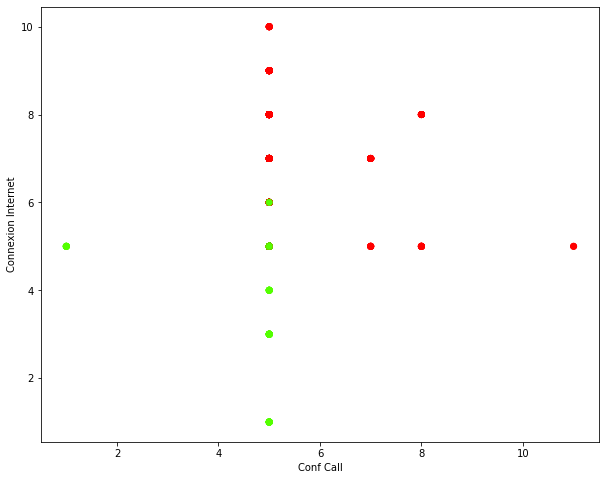

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,7], c=clusters, cmap='prism') # plot points with cluster dependent colors
plt.xlabel(d_cluster.columns[0])
plt.ylabel(d_cluster.columns[7])
plt.show()

## Now that we have confirmed the firmness of our formula, we can move to classification

# Classification

## Dependency between our target and the categorical features using chi² distance


### The categorical features that we are going to keep have to fulfill these conditions : 
- Missing values < 700 (half of our data)
- Unique categories < 10
- P-value < alpha

1410
Feature :  Sexe
P value =  0.09221811336650232
P-value > alpha : H0 variables independent, we can remove this column


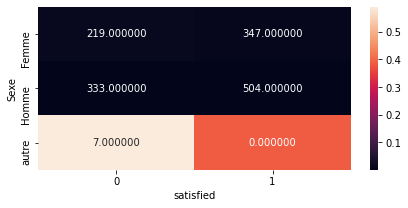

1410
Feature :  Operator_name
P value =  0.0003419701342826751
P-Value < alpha : H1 


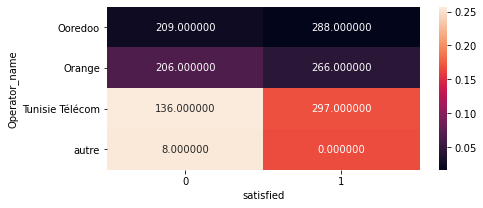

1410
Feature :  City
P value =  1.285276237029089e-19
P-Value < alpha : H1 


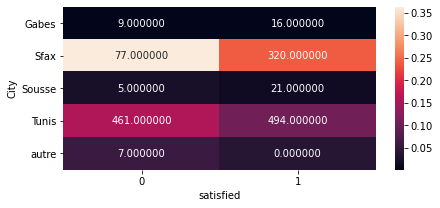

1410
Feature :  17  S7 Pour Orange, quel énoncé décrit le mieux la situation de votre entreprise? 
P value =  6.045373327698717e-19
P-Value < alpha : H1 


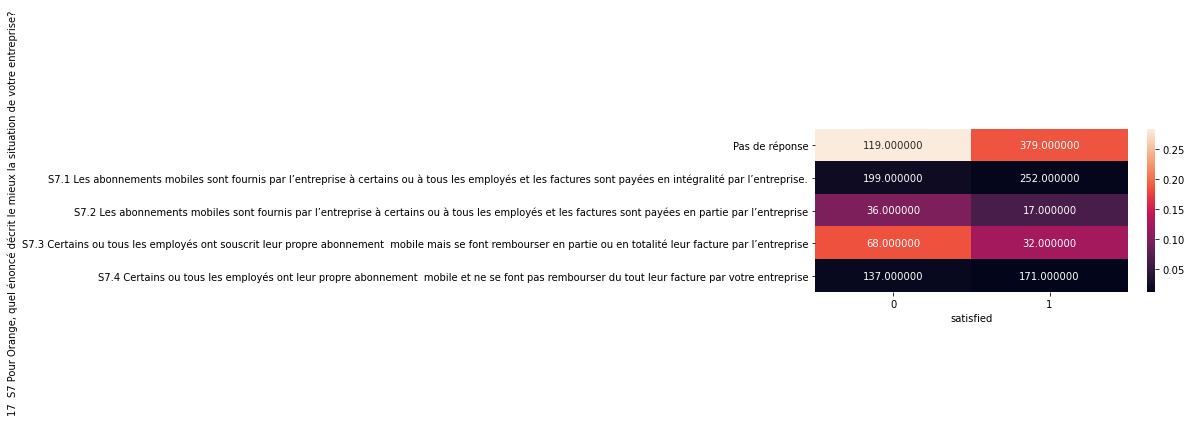

1410
Feature :  46 Q07A. qu’avez-vous fait dans les 12 derniers mois :
P value =  4.637386156006869e-28
P-Value < alpha : H1 


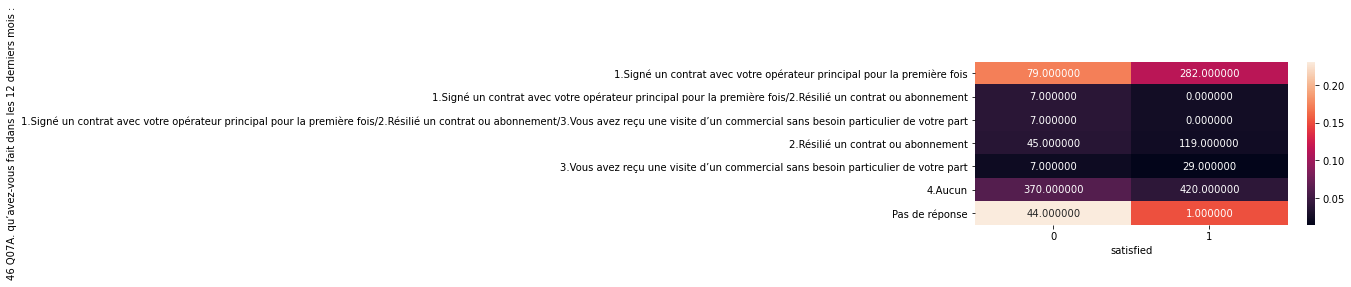

1410
Feature :  66 -  Q15. Arrivez-vous à passer votre appel dès la première tentative ? 
P value =  3.698899599240931e-24
P-Value < alpha : H1 


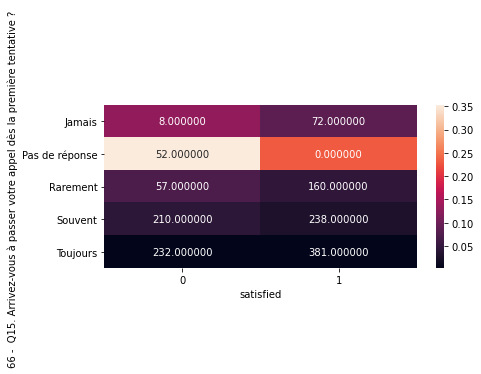

1410
Feature :  16  S6. Depuis combien de temps votre entreprise est-elle cliente de cet opérateur principal ?
P value =  2.810735024149554e-20
P-Value < alpha : H1 


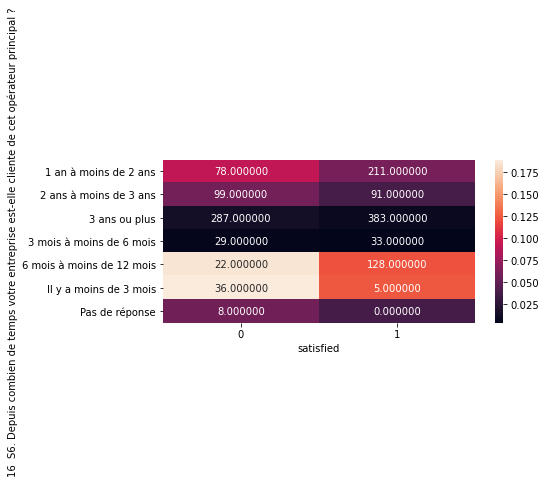

1410
Feature :  20  S8. Quel type d’offre votre entreprise ou vos salariés ont-ils le plus souscrit chez votre opérateur principal  ?
P value =  1.4402765066016292e-06
P-Value < alpha : H1 


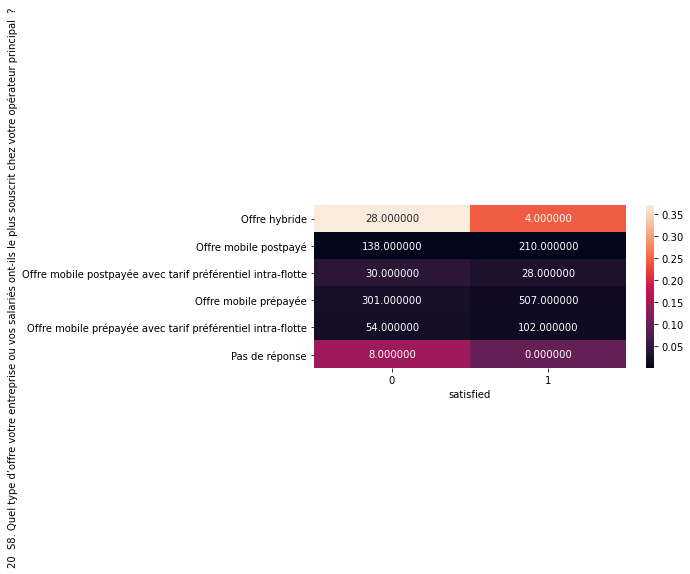

1410
Feature :  113  Q27otre entreprise envisage-t-elle de souscrire une offre Internet mobile pour un ou plusieurs salariés ?
P value =  1.0918108229209983e-48
P-Value < alpha : H1 


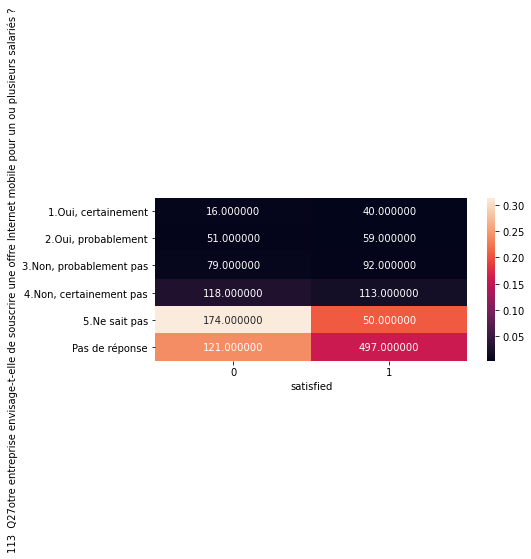

1410
Feature :  151 Q46. Pour quel autre opérateur principal changeriez-vous ?
P value =  0.7305313487707259
P-value > alpha : H0 variables independent, we can remove this column


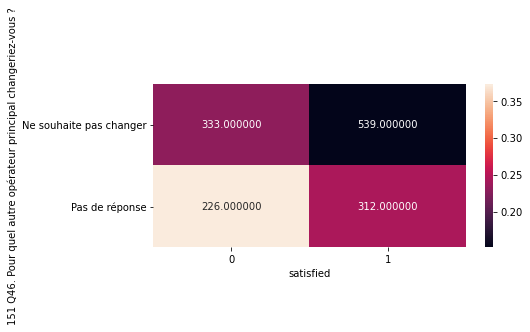

['Operator_name', 'City', '17  S7 Pour Orange, quel énoncé décrit le mieux la situation de votre entreprise? ', '46 Q07A. qu’avez-vous fait dans les 12 derniers mois :', '66 -  Q15. Arrivez-vous à passer votre appel dès la première tentative ? ', '16  S6. Depuis combien de temps votre entreprise est-elle cliente de cet opérateur principal ?', '20  S8. Quel type d’offre votre entreprise ou vos salariés ont-ils le plus souscrit chez votre opérateur principal  ?', '113  Q27otre entreprise envisage-t-elle de souscrire une offre Internet mobile pour un ou plusieurs salariés ?']


In [40]:

def contingency(X,data,Y):
       
    #Contingency table : for each value of Y, the respective total of X
    ok=True
    cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
    cont.replace({np.NaN:0},inplace=True)
    
    
    print('Feature : ',X)
    #Chi2 stat, we only need the p_value and the independency table which are st_p and st_exp
    st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
    print("P value = ",st_p)
    if(st_p>0.01):
        print('P-value > alpha : H0 variables independent, we can remove this column')
        ok=False
    else:
        print('P-Value < alpha : H1 ')
    
  
    indep=st_exp
    
    #The chi2 independency test relies on comparing the observed values against the expected ones with the following coefficient
    
    #coef = (n(i,j) - f(i)*n(j))² / (f(i)*n((j)))
    #the pvalue is the sum of that coefficient
    c = cont.fillna(0) # Replace null values with 0
    measure = (c-indep)**2/indep
    #For the heatmap, we divide the coeficients over total N 
    xi_n = measure.sum().sum() 
    table = measure/xi_n
    rcParams['figure.figsize'] = 7, 3
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1],fmt="f")
    
    plt.show()
    return ok
#Main split
df_class=df_init.copy()
Y=df_class.loc[:,'satisfied']
df_class=df_class.drop(columns='satisfied')
X=df_class.loc[:,:]

# determine categorical and numerical features
numerical_ix = X.select_dtypes(include=['int64', 'float64','int8']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
to_keep=[]


for c in categorical_ix:
    
    if ((len(df_init[c][df_init[c]=='Pas de réponse'])<700) and (len(df_init[c].unique())<10)) :
        print(df_init[c][(df_init[c]!="") & (df_init[c]!=np.NaN)].count())
        if(contingency(c,df_init,'satisfied')):
            to_keep.append(c)
print(to_keep)

In [41]:
print(len(to_keep))

8


### Dependency between the numerical features and the target

(1410,)
(1410, 104)


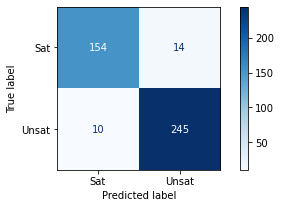

Le train score : 0.9594731509625126
Le test score  : 0.9432624113475178
              precision    recall  f1-score   support

           0     0.9390    0.9167    0.9277       168
           1     0.9459    0.9608    0.9533       255

    accuracy                         0.9433       423
   macro avg     0.9425    0.9387    0.9405       423
weighted avg     0.9432    0.9433    0.9431       423



In [42]:




Yq=df_init.loc[:,'satisfied'].values

Xq=df_init[numerical_ix].values
imputers=SimpleImputer(missing_values=np.NaN,strategy='mean')

Xq=imputers.fit_transform(Xq)
print(Yq.shape)
print(Xq.shape)
X_train, X_test, y_train, y_test = train_test_split(Xq, Yq, test_size=0.3,random_state=420,stratify=Yq)

model = LogisticRegression(random_state=0,max_iter=9999).fit(X_train, y_train)
model.fit( X_train, y_train)
plot_confusion_matrix(model, X_test, y_test, display_labels=['Sat','Unsat'], cmap=plt.cm.Blues)
plt.show()
print('Le train score :', model.score(X_train, y_train))
print('Le test score  :', model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4,zero_division=0 ))


#### We can keep our numerical features

## Dividing our data to training and validation dataset

In [43]:

#Main split
Y=df_init.loc[:1200,'satisfied']
Yval=df_init.loc[1201:,'satisfied']
l=numerical_ix.values.tolist()
#print(l)
to_keep.extend(l)
print(len(to_keep))
X=df_init.loc[:1200,to_keep]
Xval=df_init.loc[1201:,to_keep]
Xval.drop(columns='Client_id',inplace=True)
X.drop(columns='Client_id',inplace=True)
X.head()
print(Xval.shape,X.shape)

112
(209, 111) (1201, 111)


## Encoding categorical features

In [44]:
#Encoding
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(handle_unknown = 'ignore'),slice(0,8))],remainder='passthrough')
X=np.array(ct.fit_transform(X))
Xval=np.array(ct.transform(Xval))


In [45]:
len(ct.named_transformers_['encoder'].get_feature_names())
nums=l[1:]
encoded=ct.named_transformers_['encoder'].get_feature_names().tolist()
encoded.extend(nums)

In [46]:
len(encoded)


147

In [47]:
print(X.shape)

(1201, 147)


## Handling missing values with the mean

In [48]:
#Missing values
imputer=SimpleImputer(missing_values=np.NaN,strategy='mean')
X=imputer.fit_transform(X)
Xval=imputer.transform(Xval)
print(X.shape,Xval.shape)

(1201, 147) (209, 147)


In [49]:
print(X)

[[ 1.          0.          0.          0.          0.          0.
   1.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   1.          0.          5.77241379  6.81511747  9.          6.85714286
   6.51515152  5.          6.30835735  6.54318418  9.          6.
   6.         11.          6.60224719  5.38815789  4.82142857  5.37583893
   0.          5.92857143  6.18624642  6.01851852  6.4         6.28939828
   0.          5.43965517  6.67307692  8.          6.70192308  6.08552632
   5.765625    6.16314199  6.62650602  9.          6.          6.00657895
   6.80645161  6.70694864  5.80357143  0.7012987   5.64864865  8.
   4.59459459  5.          8.       

## Splitting data to train and test

In [50]:
#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.26,random_state=420,stratify=Y)


## Scaling data

In [51]:
#Scaling (must be done after splitting data)
Scaler=RobustScaler()

X_train[:,45:]=Scaler.fit_transform(X_train[:,45:])
X_test[:,45:]=Scaler.transform(X_test[:,45:])
Xval[:,45:]=Scaler.transform(Xval[:,45:])

In [52]:
len(X_train[0])
print(sum(y_test))

188


## Confusion matrix and roc curve for model validation

In [53]:
def plot_confMatrix(model,X_train,y_train,X_test, y_test,name):    

    model.fit( X_train, y_train)
    plot_confusion_matrix(model, X_test, y_test, display_labels=['0','1'], cmap=plt.cm.Blues)
    plt.show()
    
    print('Train score :', model.score(X_train, y_train))
    print('Test score  :', model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4 ))
    
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    print('Roc = ',roc_auc_score(y_test, y_pred_proba))

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim(-0.01, 1)
    plt.ylim(0, 1)
    plt.plot(fpr, tpr, label=name)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

    plt.show()
    
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred,average='binary', pos_label=1)
    scores = pd.DataFrame(columns=['Precision','Recall','F1','ROC','Train Score','Test Score'])
    scores.loc[name] = [precision, recall, f1
                        ,roc_auc_score(y_test, y_pred_proba)
                        ,model.score(X_train, y_train)
                        ,model.score(X_test, y_test)]
    print('----------------------------------------')
    
    print(scores)
    return scores



## Gridsearch for the best params

In [54]:
param_grid = {'n_neighbors' : np.arange(5,15),
              'metric' : ['euclidean', 'manhattan','minkowski'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid , cv=5,n_jobs=-1)

grid.fit(X_train, y_train)
grid.best_params_
T1=grid.best_params_


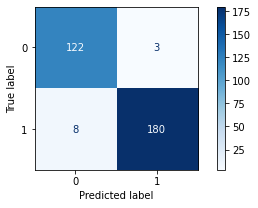

Train score : 0.9853603603603603
Test score  : 0.9648562300319489
              precision    recall  f1-score   support

           0     0.9385    0.9760    0.9569       125
           1     0.9836    0.9574    0.9704       188

    accuracy                         0.9649       313
   macro avg     0.9610    0.9667    0.9636       313
weighted avg     0.9656    0.9649    0.9650       313

Roc =  0.990936170212766


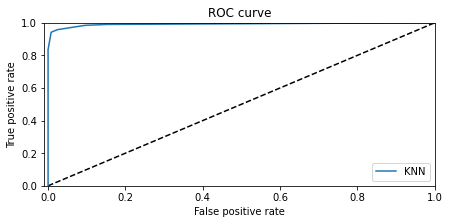

----------------------------------------
     Precision    Recall       F1       ROC  Train Score  Test Score
KNN   0.983607  0.957447  0.97035  0.990936      0.98536    0.964856


In [55]:

KNN = KNeighborsClassifier(n_neighbors=T1['n_neighbors']  ,metric=T1['metric'] ,algorithm=T1['algorithm'])
Res=plot_confMatrix(KNN,X_train,y_train,X_test, y_test,'KNN')

In [56]:
y_pred = KNN.predict(Xval)
print(classification_report(Yval, y_pred, digits=4 ))

              precision    recall  f1-score   support

           0     0.9875    0.9875    0.9875        80
           1     0.9922    0.9922    0.9922       129

    accuracy                         0.9904       209
   macro avg     0.9899    0.9899    0.9899       209
weighted avg     0.9904    0.9904    0.9904       209



## Random forest model for classification

#### We chose this model because our main purpose besides of prediction is to analyze the most important features which is provided by this model

In [57]:
RF = RandomForestClassifier()
param_grid = {
              'criterion' : ['gini', 'entropy'],             
              'max_depth' : np.arange(1,15),      
             }
grid = GridSearchCV(RF, param_grid=param_grid , cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_
T3=grid.best_params_

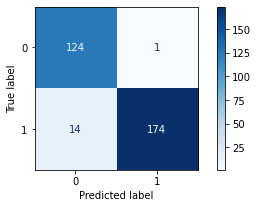

Train score : 0.9594594594594594
Test score  : 0.952076677316294
              precision    recall  f1-score   support

           0     0.8986    0.9920    0.9430       125
           1     0.9943    0.9255    0.9587       188

    accuracy                         0.9521       313
   macro avg     0.9464    0.9588    0.9508       313
weighted avg     0.9561    0.9521    0.9524       313

Roc =  0.994468085106383


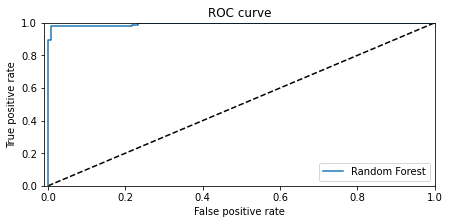

----------------------------------------
               Precision    Recall        F1       ROC  Train Score  \
Random Forest   0.994286  0.925532  0.958678  0.994468     0.959459   

               Test Score  
Random Forest    0.952077  


In [58]:

RF = RandomForestClassifier(criterion=T3['criterion'],max_depth=6)
Res=plot_confMatrix(RF,X_train,y_train,X_test, y_test,'Random Forest')

[]

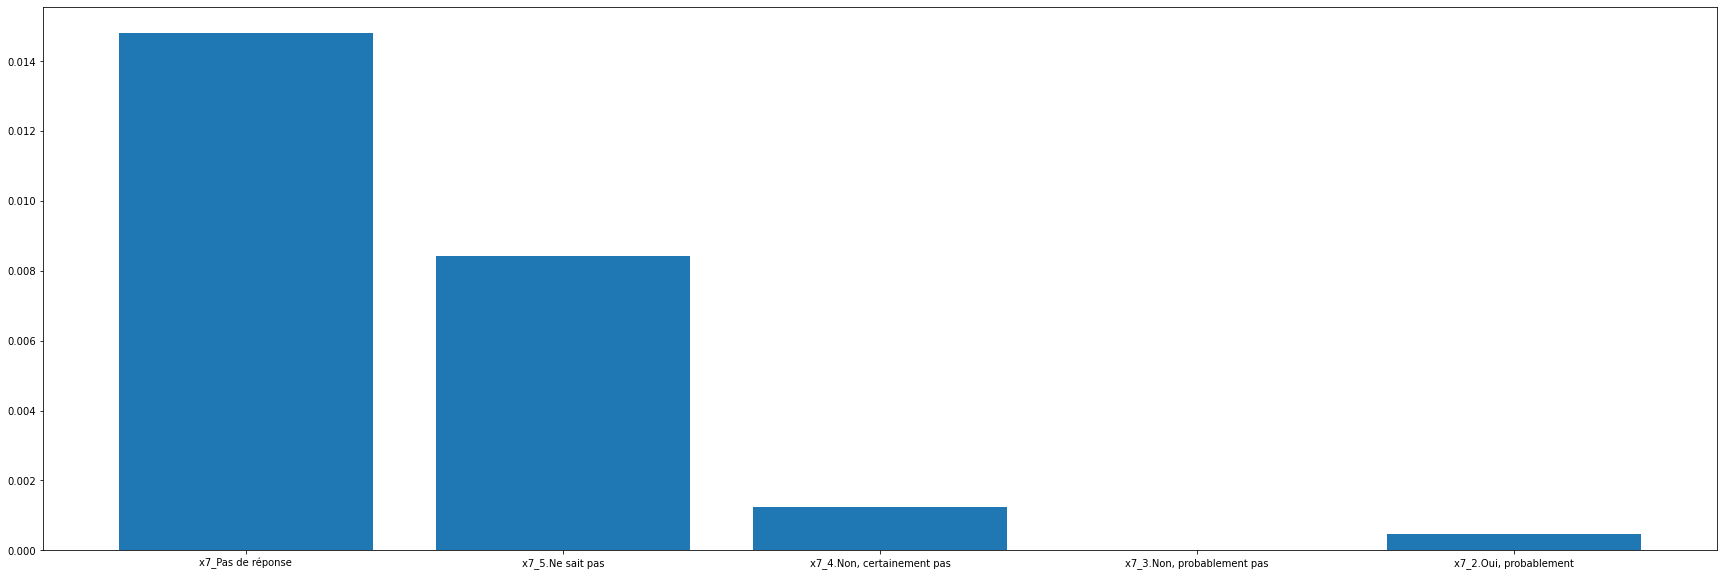

In [64]:
import graphviz
from sklearn import tree


importance = RF.feature_importances_


zipped_lists = zip(encoded, importance)
sorted_pairs = sorted(zipped_lists,reverse=True)
plt.figure(figsize=(30,10))

tuples = zip(*sorted_pairs)
list1, list2 = [ list(tuple) for tuple in  tuples]

plt.bar(list1[:5],list2[:5])

plt.plot()

In [65]:


dot_data= tree.export_graphviz(RF.estimators_[len(RF.estimators_)-1],  
                                feature_names=encoded,  
                                class_names=['0','1'],
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH